<a href="https://colab.research.google.com/github/RuikunZhou/Unknown_Neural_Lyapunov/blob/main/Koopman_Lyapunov_Marabou_CDC329.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Koopman Lyapunov function for VDP

In [1]:
import sys
sys.path.append('/Users/r54zhou/Marabou')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm
import scipy.io as sio
from scipy.integrate import odeint

import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

# from maraboupy import Marabou
import timeit 


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Generating dataset

In [3]:
def f_value_ct(x,t): # C-T
    y = np.zeros(2)
    # y = torch.zeros_like(x)
    y[0] = - x[1]
    y[1] = x[0] + (x[0]**2-1)*x[1]
    return y

In [4]:
def f_value(x,tspan): # D-T
    y = torch.zeros_like(x)
    y[:,0] = - x[:,1]*tspan + x[:,0]
    y[:,1] = (x[:,0] + (x[:,0]**2-1)*x[:,1])*tspan + x[:,1]
    return y

In [5]:
# Solve the ODE using odeint
N_sample = 200000
y0 = 2.4*np.random.rand(N_sample,2) - 1
y_output = np.zeros_like(y0)
t = np.linspace(0, 0.01, 101)

for i in range(N_sample):
    y = odeint(f_value_ct, y0[i,:], t)
    y_output[i,:] = y[-1,:]

x_f = torch.tensor(y0).to(dtype=torch.float64).to(device)
t_f = torch. tensor(y_output).to(dtype=torch.float64).to(device)


## Koopman autoencoder to learn the dynamics

In [6]:

class KoopmanAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, activation_fn = torch.relu, dtype = torch.float64 ):
        super(KoopmanAutoencoder, self).__init__()
        self.dtype = torch.float64
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.activation_fn = activation_fn
        
        # Encoder layers
        self.fc1 = nn.Linear(input_size, hidden_size).type(dtype)
        self.fc2 = nn.Linear(hidden_size, hidden_size).type(dtype)
        self.fc3 = nn.Linear(hidden_size, latent_size).type(dtype)
        # self.fc4 = nn.Linear(hidden_size, latent_size)
        
        # Decoder layers
        self.fc5 = nn.Linear(latent_size, hidden_size).type(dtype)
        self.fc6 = nn.Linear(hidden_size, hidden_size).type(dtype)
        self.fc7 = nn.Linear(hidden_size, input_size).type(dtype)
        # self.fc8 = nn.Linear(hidden_size, input_size)

        # Koopman dynamics layer
        self.dynmaics = nn.Linear(latent_size, latent_size, bias=False).type(dtype)

    def encode(self, x):
        e_h1 = self.activation_fn(self.fc1(x))
        e_h2 = self.activation_fn(self.fc2(e_h1))
        encoder = self.fc3(e_h2)
        return encoder
    
    def decode(self, x):
        d_h1 = self.activation_fn(self.fc5(x))
        d_h2 = self.activation_fn(self.fc6(d_h1))
        decoder = self.fc7(d_h2)
        return decoder
    
    def forward(self, x):
        self.encoder = self.encode(x)
        self.Koopman_d = self.dynmaics(self.encoder)
        self.decoder = self.decode(self.Koopman_d)
        return self.decoder
    



### Training

100%|██████████| 50/50 [00:21<00:00,  2.33it/s]


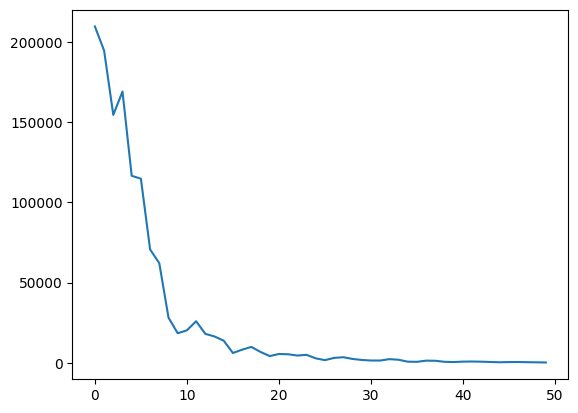

In [7]:
# Create the model instance
input_size = 2
hidden_size = 80
latent_size = 80
alpha_1 = 1e-2
alpha_2 = 1e-2
torch.manual_seed(4321)  

model = KoopmanAutoencoder(input_size, hidden_size, latent_size).to(device)

# Define the loss function and optimizer
loss_func = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

x_f = x_f.to(device)
t_f = t_f.to(device)

# Train the model
losses = []
for epoch in tqdm(range(50)):
    # Get a batch of data
    
    y_nn = model(x_f)
    # loss = loss_func(y_nn,t_f)
    x_estimate = model.decode(model.encode(x_f))
    phi_next = model.encode(t_f)
    phi_x = model.encode(x_f)
    KoopmanM = model.dynmaics.weight.data  # Loss function
    loss = loss_func(y_nn,t_f) + alpha_1*loss_func(x_estimate, x_f) \
          + alpha_2*loss_func(torch.matmul(KoopmanM, phi_x), phi_next) 
    losses.append(loss.item())
    
    # Backpropagate the error and update the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        torch.cuda.empty_cache()
    
plt.plot(losses)

In [18]:
losses[-1]

0.47561301666767714

100%|██████████| 20/20 [00:07<00:00,  2.69it/s]


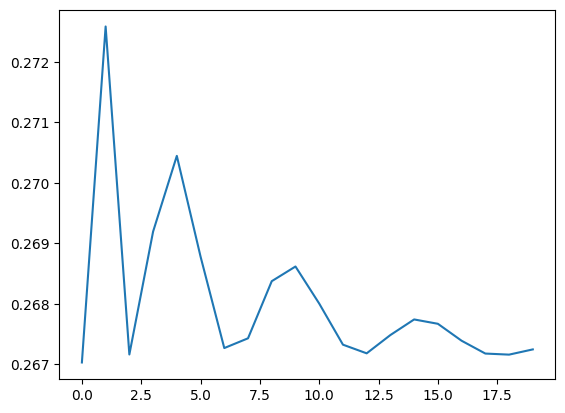

In [27]:
# train more epoches with smaller learning rate
loss_func = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)
model = model.to(device)

# Train the model
losses = []
for epoch in tqdm(range(20)):
    y_nn = model(x_f)
    loss = loss_func(y_nn,t_f)
    losses.append(loss.item())
    
    # Backpropagate the error and update the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        torch.cuda.empty_cache()
    
plt.plot(losses)

### Load and save model

In [23]:
# save model as a file
torch.save(model.cpu(), 'VDP_Koopman329_80_80nodes_simpleLoss.pt')

# load model from a file
# model = torch.load('/content/drive/MyDrive/Colab Notebooks/VDP_Koopman225_8_16nodes.pt').to(device)
# model = torch.load('VDP_Koopman327_48_48nodes.pt').to(device)


In [ ]:
input_size = 2
dummy_input = torch.randn(1, input_size, dtype=torch.float64)
onnx_filename = "dynamics_ReLU329_simpleLoss.onnx"
torch.onnx.export(model, dummy_input, onnx_filename)

In [ ]:
# learned dynamics
# encoder
e_w1 = model.fc1.weight
e_w2 = model.fc2.weight
e_w3 = model.fc3.weight

e_b1 = model.fc1.bias
e_b2 = model.fc2.bias
e_b3 = model.fc3.bias

# dynamics
f_w = model.dynmaics.weight

# decoder
d_w1 = model.fc5.weight
d_w2 = model.fc6.weight
d_w3 = model.fc7.weight

d_b1 = model.fc5.bias
d_b2 = model.fc6.bias
d_b3 = model.fc7.bias

### Plot the approximated results

In [24]:
# dataset for plotting
N_p = 500
xp = np.linspace(-1.2,1.2,N_p, dtype = float).reshape(N_p,1)
xx = np.linspace(-1.2,1.2,N_p, dtype = float).reshape(N_p,1)

for n in range(1): # for dim n
    xp = np.concatenate((xp,xx), axis=1 ) 

xp = torch.tensor(xp)
Xp = xp.to(dtype=torch.float64)

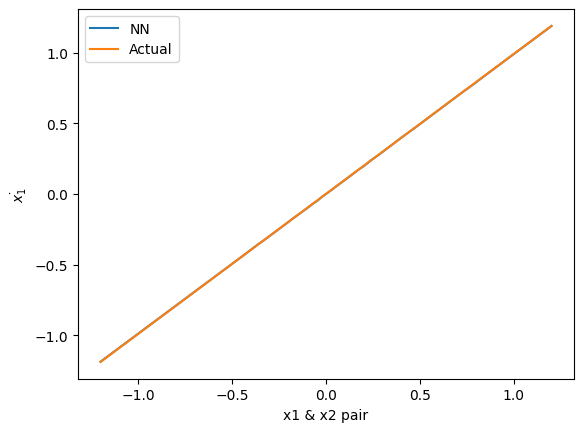

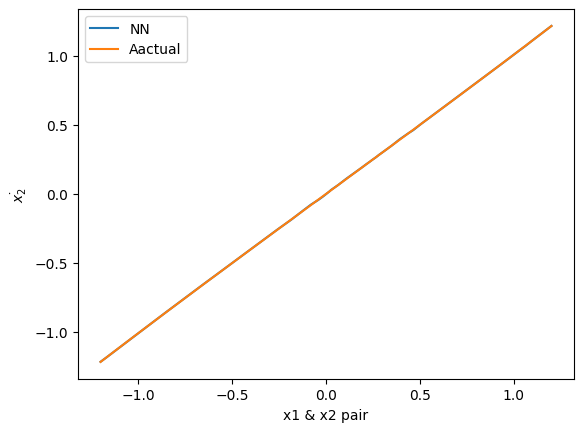

In [29]:
model_plot = model.cpu()
yp = model_plot(Xp)
tp = f_value(xp,tspan=0.01)

with torch.no_grad():
    plt.figure(1)
    plt.plot(xp[:,0], yp[:,0],label='NN')
    plt.plot(xp[:,0], tp[:,0], label='Actual')
    plt.xlabel('x1 & x2 pair')
    plt.ylabel('$\dot{x_1}$')
    plt.legend(loc = 0)

    plt.figure(2)
    plt.plot(xp[:,0],yp[:,1],label='NN')
    plt.plot(xp[:,0],tp[:,1],label='Aactual')
    plt.xlabel('x1 & x2 pair')
    plt.ylabel('$\dot{x_2}$')
    plt.legend()

## Learn the Koopman Lyapunov function

In [30]:
import random
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

In [50]:
def Plot3D(X, Y, V, r):
    # Plot Lyapunov functions  
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d') # 
    ax.plot_surface(X,Y,V, rstride=5, cstride=5, alpha=0.5, cmap=cm.coolwarm)
    ax.contour(X,Y,V,10, zdir='z', offset=0, cmap=cm.coolwarm)
    
    # Plot Valid region 
    theta = np.linspace(0,2*np.pi,50)
    xc = r*np.cos(theta)
    yc = r*np.sin(theta)
    ax.plot(xc[:],yc[:],'r',linestyle='--', linewidth=2 ,label='Valid region')
    plt.legend(loc='upper right')
    return ax

def Plotflow(ax, Xd, Yd, t):
    # Plot phase plane 
    DX, DY = f([Xd, Yd],t)
    ax.plt.streamplot(Xd,Yd,DX,DY, color=('gray'), linewidth=0.5,
                  density=0.8, arrowstyle='-|>', arrowsize=1)

def f(y,t):
    x1,x2 = y
    dydt = [-x2,
            x1+(x1**2-1)*x2]
    return dydt


In [37]:
def ROAplot(ax, X_,Y_, V, r=1.2): 
  # Vaild Region
  # # Define square vertices
  # square_vertices = [(-r, -r), (-r, r), (r, r), (r, -r), (-r, -r)]

  # plot direction field
  xd = np.linspace(-r, r, 100) 
  yd = np.linspace(-r, r, 100)
  Xd, Yd = np.meshgrid(xd,yd)
  t = np.linspace(0,2,100)

  ax.contour(X_,Y_,V,15,linewidths=0.4, colors='k')
  c1 = ax.contourf(X_,Y_,V,8, alpha=0.4, cmap=cm.coolwarm)

  ax.set_title('Van der Pol')
  ax.set_xlabel('x1')
  ax.set_ylabel('x2')

In [33]:
def Plotflow_all(Xd, Yd, t):
    # Plot phase plane 
    DX, DY = f([Xd, Yd],t)
    plt.streamplot(Xd,Yd,DX,DY, color=('gray'), linewidth=0.5,
                  density=0.8, arrowstyle='-|>', arrowsize=1)

## Calculate Koopman Lyapunov function

In [34]:
# plot V_i to pick good Lyapunov function candidates

delta = 0.01
r = 1.2
x_ = np.arange(-r, r, delta)
n_plot = len(x_)

x_plot = []
for i in range(n_plot): 
    for j in range(n_plot):
        x_plot.append([x_[j],x_[i]])

x_plot = torch.tensor(x_plot, dtype=torch.float64)

X_, Y_ = np.meshgrid(x_, x_) # for 3D plot

# obtain the K matrix and the basis
model.eval()

model = model.cpu()

with torch.no_grad():
    K = model.dynmaics.weight.cpu().numpy()
    basis = model.encode(x_plot).cpu()

""" EXTRACT EIGENFUNCTIONS """
mu_,phi_ = np.linalg.eig(K)


In [35]:
# check stable modes
stable = np.argwhere(np.absolute(mu_)<1).T[0]  
phi_stable = phi_[:,stable] 

stable.shape

(80,)

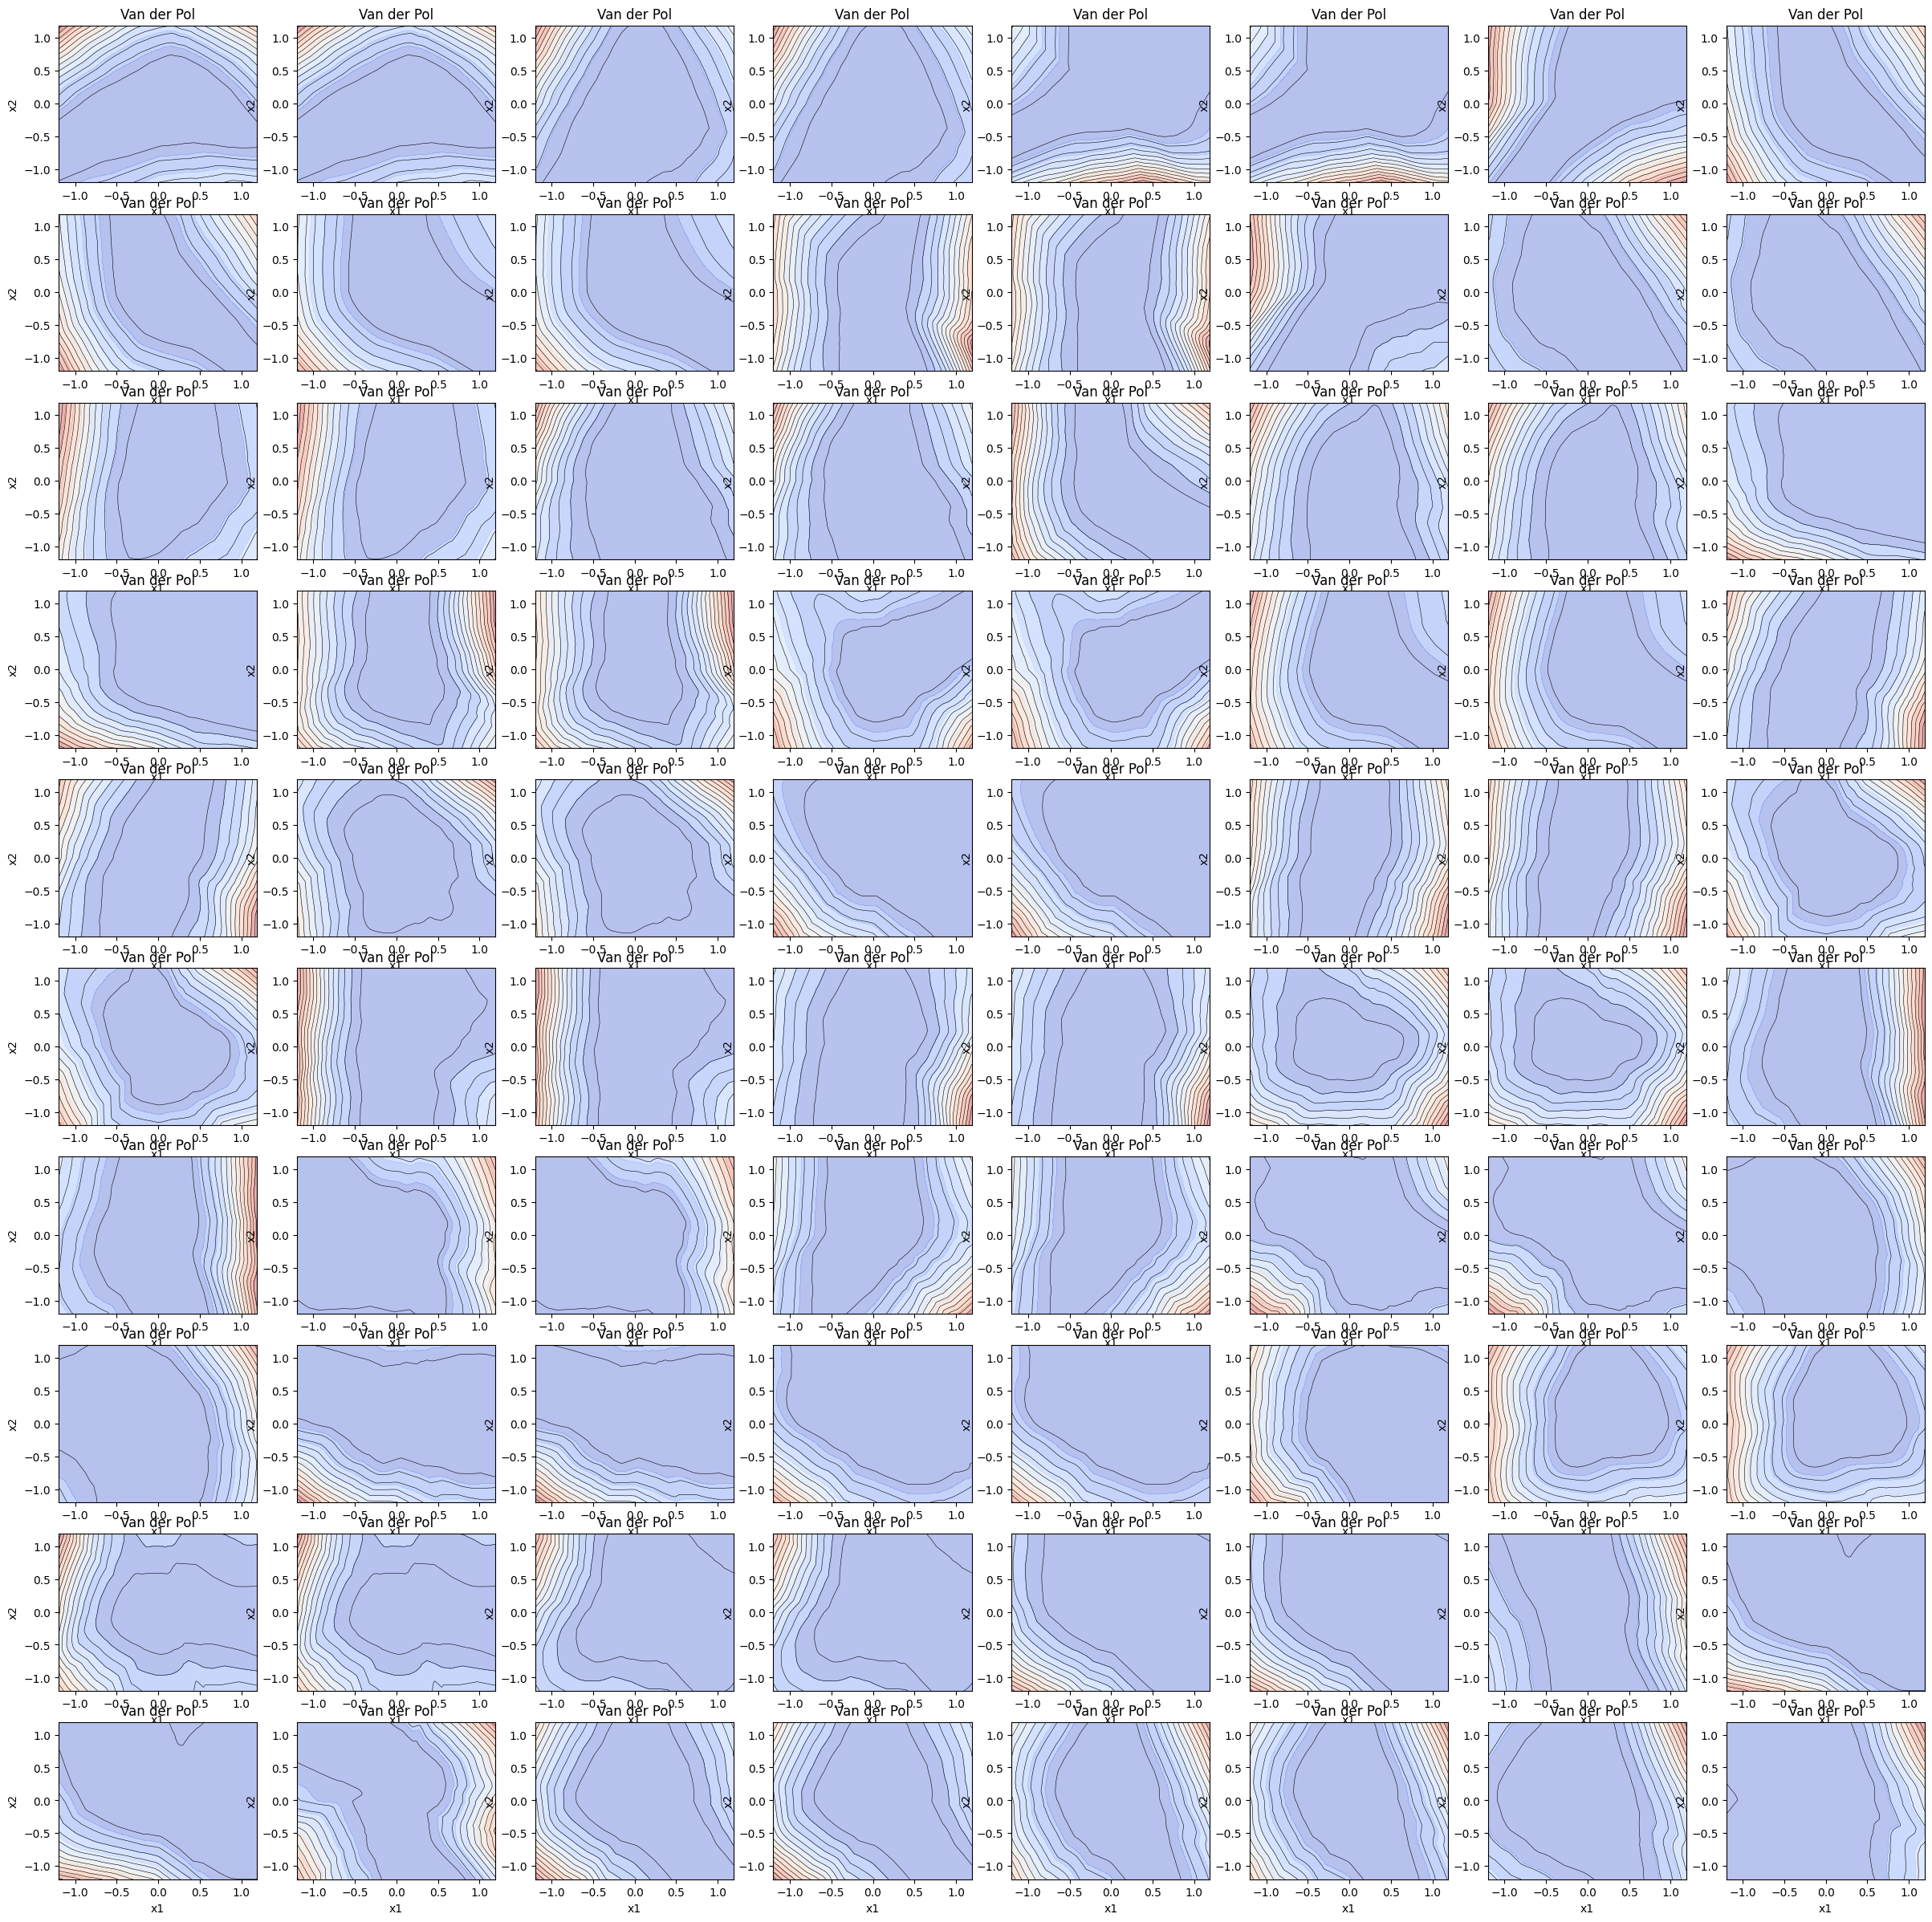

In [65]:
n_columns = 8
n_rows = int(len(mu_)/n_columns)
fig, axs = plt.subplots(n_rows, n_columns, figsize=(30, 30))

x0 = torch.tensor([0.,0.], dtype=torch.float64)
V0_basis = model.encode(x0).cpu()

V_total = np.zeros((hidden_size, basis.shape[0]))
V0_psi = np.matmul(phi_.T,V0_basis.detach().numpy())

psi = np.matmul(phi_.T, basis.T)
V_total = 0.5*np.absolute(psi - V0_psi.reshape(-1,1))**2

for i in range(len(mu_)):
  # psi_i = np.matmul(phi_[:,i].reshape(-1,1).T, basis.detach().numpy().T) # one eigenfunction
  # V_i = np.absolute(psi_i - V0_psi[i])
  V_i = V_total[i,:]
  V_i = V_i.reshape(n_plot,n_plot)

  ROAplot(axs[int(np.floor(i/n_columns)), np.mod(i,n_columns)], X_,Y_,V_i,r)
  
# plt.tight_layout
plt.show()

In [222]:
# weights = np.ones_like(weights)

In [269]:
weights = np.array([0.0, 0.0, 0.8, 0.8, 0.8, 0.8, 0.0, 0.0, \
                    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, \
                    0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, \
                    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, \
                    0.0, 5.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, \
                    0.0, 0.5, 0.5, 0.0, 0.0, 0.5, 0.5, 0.0, \
                    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, \
                    0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.5, 1.5, \
                    1.8, 1.8, 1.0, 1.0, 0.0, 0.0, 0.0, 0.2, \
                    0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, \
                    ])

V = np.dot(weights, V_total)
V = V.reshape(n_plot,n_plot)
X_, Y_ = np.meshgrid(x_, x_)

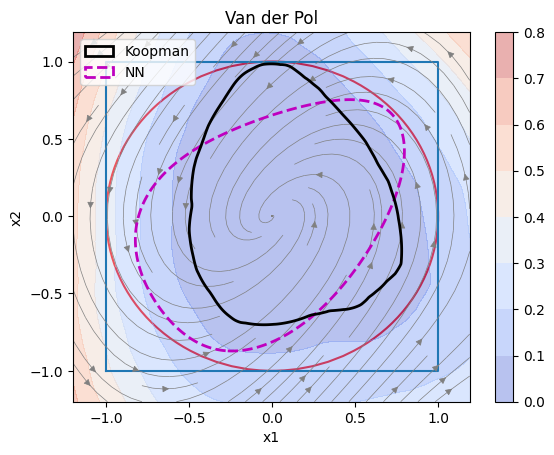

In [277]:
ax = plt.gca()
r_sq = 1.

# Vaild Region
C = plt.Circle((0, 0),r_sq, color='r', linewidth=1.5, fill=False, label='ROA')
ax.add_artist(C)

# Define square vertices
square_vertices = [(-r_sq, -r_sq), (-r_sq, r_sq), (r_sq, r_sq), (r_sq, -r_sq), (-r_sq, -r_sq)]

# Unzip the vertices into two lists (x-coordinates and y-coordinates)
x_coords, y_coords = zip(*square_vertices)

C = plt.plot(x_coords, y_coords) 

# plot direction field
# xd = np.linspace(-r_sq, r_sq, 100) 
# yd = np.linspace(-r_sq, r_sq, 100)
# Xd, Yd = np.meshgrid(xd,yd)
Xd, Yd = X_, Y_
t = np.linspace(0,2,100)
Plotflow_all(Xd, Yd, t) 

V_neural = np.tanh((0.55936360359191895 + 1.3911000490188599 * np.tanh((-1.2856053113937378 + 1.9734891653060913 * Xd - 1.1179620027542114 * Yd)) - 1.6470109224319458 * np.tanh((-1.1790347099304199 + 0.12229307740926743 * Xd + 0.023527547717094421 * Yd)) + 1.5415596961975098 * np.tanh((-0.95915126800537109 - 0.40343287587165833 * Xd + 1.5067094564437866 * Yd)) + 0.6826709508895874 * np.tanh((0.89481496810913086 - 0.05955226719379425 * Xd + 0.028606858104467392 * Yd)) \
    + 1.1617172956466675 * np.tanh((1.1949435472488403 - 0.18072269856929779 * Xd - 0.050765510648488998 * Yd)) - 1.253376841545105 * np.tanh((1.2111023664474487 + 1.1277693510055542 * Xd + 0.94527208805084229 * Yd)))) 

ax.contour(Xd,Yd,V_neural-0.7,0,linewidths=2, colors='m',linestyles='--')
ax.contour(Xd,Yd,V-0.06,0,linewidths=2, colors='k')
c1 = ax.contourf(Xd,Yd,V,8, alpha=0.4,cmap=cm.coolwarm)
plt.colorbar(c1)

plt.title('Region of Attraction')
plt.title('Van der Pol')
plt.legend([plt.Rectangle((0,0),1,2,color='k',fill=False,linewidth = 2),plt.Rectangle((0,0),1,2,color='m',fill=False,linewidth = 2,linestyle='--')],['Koopman','NN'],loc='upper left')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

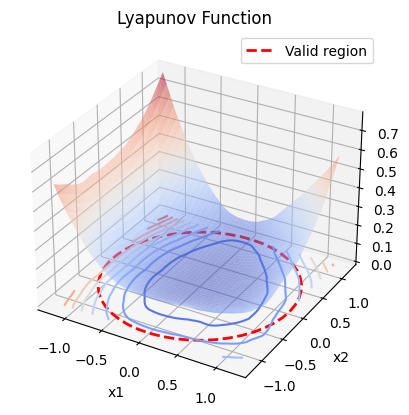

In [278]:
r = 1.2
ax = Plot3D(X_,Y_,V, r)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('V')
plt.title('Lyapunov Function')
# plt.savefig('vdp_lf.png', dpi=500, bbox_inches='tight')
plt.show()

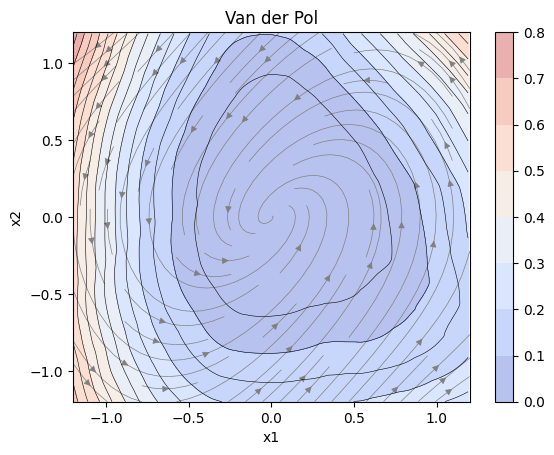

In [279]:
ax = plt.gca()

# # Vaild Region
# C = plt.Circle((0, 0),r, color='r', linewidth=1.5, fill=False, label='ROA')
# ax.add_artist(C)

# plot direction field
xd = np.linspace(-r, r, 100) 
yd = np.linspace(-r, r, 100)
Xd, Yd = np.meshgrid(xd,yd)
t = np.linspace(0,2,100)
Plotflow_all(Xd, Yd, t) 

ax.contour(X_,Y_,V,15,linewidths=0.4, colors='k')
c1 = ax.contourf(X_,Y_,V,8, alpha=0.4,cmap=cm.coolwarm)
plt.colorbar(c1)

plt.title('Region of Attraction')
plt.title('Van der Pol')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## Learn the Lyapunov function

In [137]:
class KoopmanLyapunov(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation_fn = torch.relu, dtype = torch.float64):
        super(KoopmanLyapunov, self).__init__()
        self.dtype = torch.float64
        # self.input_size = input_size
        # self.hidden_size = hidden_size
        # self.output_size = output_size
        self.activation_fn = activation_fn
 
        self.fc1 = nn.Linear(input_size, hidden_size, bias=True).type(dtype)
        self.fc2 = nn.Linear(hidden_size, hidden_size, bias=True).type(dtype)
        self.fc3 = nn.Linear(hidden_size, hidden_size, bias=True).type(dtype)
        self.fc4 = nn.Linear(hidden_size, output_size, bias=False).type(dtype)

    def forward(self, x):
        h1 = self.activation_fn(self.fc1(x))
        h2 = self.activation_fn(self.fc2(h1))
        h3 = self.activation_fn(self.fc3(h2)) 
        y = self.activation_fn(self.fc4(h3))
        return y


### Training

In [90]:
# N = 50000
# D_in = 2
# r = 0.5
# # x_v_o = torch.Tensor(N, D_in).uniform_(-0.1, 0.1) # add more samples around the origin
# x_v = torch.Tensor(N, D_in).uniform_(-r, r).to(dtype=torch.float64)
# X0 = torch.tensor([0.,0.])
# x_v = torch.cat((x_v, x_v_o, x0.reshape(1,-1)),0)
# x_v = torch.cat((x_v, x0.reshape(1,-1)),0)
# model = model.to('cpu')
model.to(device)

with torch.no_grad():
    K = model.dynmaics.weight.cpu().numpy()
    basis = model.encode(x_f).cpu()

""" EXTRACT EIGENFUNCTIONS """
mu,phi = np.linalg.eig(K)
x0 = x0.to(device)
V0_basis = model.encode(x0)
V0_psi = np.matmul(phi.T, V0_basis.cpu().detach().numpy())

## NN code
# train_basis = model.encode(x_v)
# V_total_train = np.zeros((hidden_size, train_basis.shape[0]))

# for i in range(len(mu_)):
#   train_psi_i = np.matmul(phi_[:,i].reshape(-1,1).T, train_basis.detach().numpy().T) # one eigenfunction
#   V_i_train = np.absolute(train_psi_i - V0_psi[i])
#   V_total_train[i,:] = V_i_train

# V_target = np.dot(weights, V_total_train)


In [ ]:
# # Solve the ODE using odeint
# x_next = torch.zeros_like(x_v)
# t = np.linspace(0, 0.001, 101)

# x_cal = x_next.numpy()

# for i in range(len(x_v)):
#     y_next = odeint(f_value_ct, x_v[i,:].clone(), t)
#     x_cal[i,:] = y_next[-1,:].copy()

# x_next = torch.tensor(x_cal).to(dtype=torch.float64)


In [155]:
x_v = torch.cat((x_f, x0.reshape(1,-1)),0)
t_v = torch.cat((t_f, x0.reshape(1,-1)),0)

weights = weights.reshape(1,-1)
# V(x_k)
train_basis = model.encode(x_v).cpu().detach().numpy()
psi_train = np.matmul(phi.T, train_basis.T)
V_train_total = 0.5*np.absolute(psi_train - V0_psi.reshape(-1,1))**2

V_target = np.matmul( weights, V_train_total)

# V(x_k+1)
basis_next = model.encode(t_v).cpu().detach().numpy()
psi_next = np.matmul(phi.T, basis_next.T)
V_next_total = 0.5*np.absolute(psi_next - V0_psi.reshape(-1,1))**2

V_next = np.matmul(weights, V_next_total)

V_targets = np.concatenate((V_target,V_next),axis = 0)
V_targets = torch.tensor(V_targets).to(dtype=torch.float64) 

In [112]:
np.min(V_train_total, axis = 1)

array([1.20370622e-34, 1.20370622e-34, 1.09838192e-34, 1.09838192e-34,
       9.66726554e-35, 9.66726554e-35, 6.35707345e-35, 1.33912316e-34,
       1.33912316e-34, 6.01853108e-34, 6.01853108e-34, 1.20370622e-34,
       1.20370622e-34, 2.16667119e-34, 3.86690622e-34, 3.86690622e-34,
       1.20370622e-34, 1.20370622e-34, 1.68556486e-33, 1.68556486e-33,
       9.62964972e-35, 4.81482486e-34, 4.81482486e-34, 8.28488418e-35,
       8.28488418e-35, 3.00926554e-35, 3.00926554e-35, 7.55419690e-34,
       7.55419690e-34, 1.54224859e-35, 1.54224859e-35, 2.30208814e-34,
       2.30208814e-34, 1.50463277e-34, 1.50463277e-34, 6.25927232e-34,
       6.25927232e-34, 1.50463277e-36, 1.50463277e-36, 2.40741243e-35,
       2.40741243e-35, 9.40395481e-36, 9.40395481e-36, 3.91204520e-34,
       3.91204520e-34, 9.03720057e-35, 9.03720057e-35, 1.35416949e-35,
       1.35416949e-35, 2.40741243e-35, 2.40741243e-35, 8.67044633e-34,
       8.67044633e-34, 6.01853108e-36, 6.01853108e-36, 2.05006215e-34,
      

In [120]:
V_next.shape

(1, 200001)

In [115]:
difference = V_next - V_target
np.max(difference)

0.0015125985805849174

In [146]:
torch.min(V_targets)

tensor(7.9454e-32, device='cuda:0', dtype=torch.float64)

100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


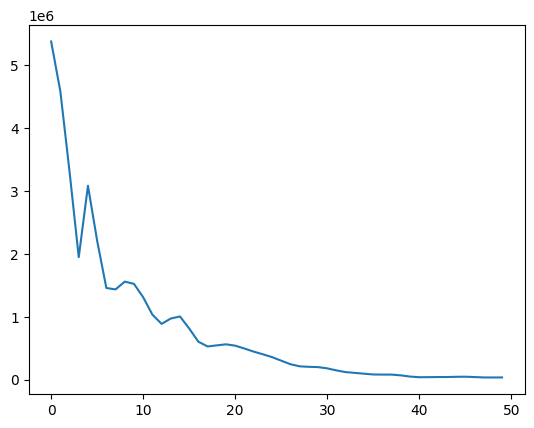

In [158]:
# Create the model instance
V_input_size = 2
V_hidden_size = 100
V_output_size = 2
torch.manual_seed(4321)  

V_func = KoopmanLyapunov(V_input_size, V_hidden_size, V_output_size).to(device) # 
X0 = torch.tensor([0.,0.], dtype = torch.float64).to(device)
V_0 = V_func(X0)

# Define the loss function and optimizer
V_loss_func = nn.MSELoss(reduction='sum')
V_optimizer = torch.optim.Adam(V_func.parameters(), lr=0.01)

# x_v = x_v.to(dtype=torch.float64)
x_v = x_v.to(device)
V_t = 100.*V_targets.to(device)

# Train the model
V_losses = []
for epoch in tqdm(range(50)):
    V_nn = V_func(x_v)
    
    V_loss = V_loss_func(V_nn,V_t.T)
    
    V_0 = V_func(X0)
    V_loss += torch.norm(V_0)
    V_loss = V_loss.float()
    V_losses.append(V_loss.item())

    # Backpropagate the error and update the weights
    V_optimizer.zero_grad()
    V_loss.backward()
    V_optimizer.step()

    with torch.no_grad():
        torch.cuda.empty_cache()

plt.plot(V_losses)

In [164]:
V_losses[-1]

85.36968231201172

In [162]:
X0

tensor([0., 0.], device='cuda:0', dtype=torch.float64)

100%|██████████| 1000/1000 [03:16<00:00,  5.10it/s]


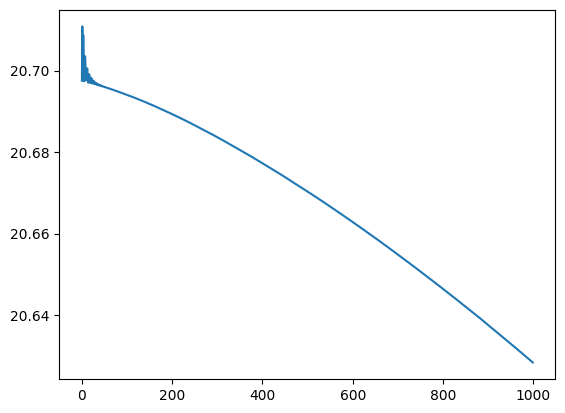

In [196]:
V_optimizer = torch.optim.Adam(V_func.parameters(), lr=0.000001)
# Train more epoche
V_losses = []
for epoch in tqdm(range(1000)):
    # Get a batch of data
    V_nn = V_func(x_v)
    
    V_loss = V_loss_func(V_nn,V_t.T)
    
    V_0 = V_func(X0)
    V_loss += 100.*torch.norm(V_0)
    V_loss = V_loss.float()
    V_losses.append(V_loss.item())
    # Backpropagate the error and update the weights
    V_optimizer.zero_grad()
    V_loss.backward()
    V_optimizer.step()

plt.plot(V_losses)

In [197]:
# check V(x0) V_0 must be zero
V_0

tensor([0., 0.], device='cuda:0', dtype=torch.float64, grad_fn=<ReluBackward0>)

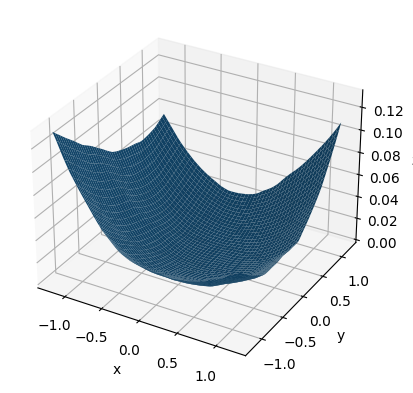

In [198]:
r = 1.2
# Define a grid of points over which to evaluate the neural network
x = torch.linspace(-r, r, 1000, dtype=torch.float64)
y = torch.linspace(-r, r, 1000, dtype=torch.float64)
X, Y = torch.meshgrid(x, y)
input_grid = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1).to(device)

# Evaluate the neural network's predictions on the input grid
V_learn = V_func(input_grid).detach()/100.
V_plot = V_learn[:,0].view(X.shape)

# Create a 3D plot of the function surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), V_plot.cpu().numpy())
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [184]:
## check the targeted V
# model = model.cpu()
input_grid = input_grid.to(torch.float64)
model = model.to(device)
train_basis_p = model.encode(input_grid).cpu()

psi_p = np.matmul(phi.T, train_basis_p.detach().T)# two or more eigenfunctions

V_total_p = np.absolute(psi_p - V0_psi.reshape(-1,1))

V_p = np.dot(weights, V_total_p)[:,0].reshape(X.shape)

# Create a 3D plot of the function surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), V_p)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

ValueError: ignored

### Load and save model for Lyapunov functions

In [199]:
# save model as a file
torch.save(V_func, 'VDP_KoopmanLyapunov_Vnext329_100_100_100nodes.pt')

# load model from a file
# model = torch.load('/content/drive/MyDrive/Colab Notebooks/VDP_Koopman225_8_16nodes.pt').to(device)
# V_func = torch.load('VDP_KoopmanLyapunov_Vnext328_50_50_50nodes.pt').to(device)

In [ ]:
# learned Lyapunov function
# encoder
v_w1 = V_func.fc1.weight
v_w2 = V_func.fc2.weight
v_w3 = V_func.fc3.weight
v_w4 = V_func.fc4.weight

v_b1 = V_func.fc1.bias
v_b2 = V_func.fc2.bias
v_b3 = V_func.fc3.bias


## Marabou verification

In [200]:
input_size = 2
dummy_input = torch.randn(1, input_size, dtype=torch.float64)
dummy_input = dummy_input.to(device)
onnx_filename = "Lyapunov_together329.onnx"
torch.onnx.export(V_func, dummy_input, onnx_filename)

In [ ]:
options = Marabou.createOptions(verbosity = 0)

filename = "Lyapunov_Vnext320.onnx"
Vnet = Marabou.read_onnx(filename)

inputVars = Vnet.inputVars[0][0]
outputVars = Vnet.outputVars[0][0]

r_ver = 0.5

# set input bounds 
Vnet.setLowerBound(inputVars[0],-r_ver )
Vnet.setUpperBound(inputVars[0], r_ver )
Vnet.setLowerBound(inputVars[1],-r_ver )
Vnet.setUpperBound(inputVars[1], r_ver )


Vnet.addInequality([outputVars[0], outputVars[1]], [1.0, -1.0], -0.002)

# set output bounds
# Vnet.setLowerBound(outputVars[0], 0.01)
# Vnet.setUpperBound(outputVars[0], 0.001)

vals = Vnet.solve(options = options)

unsat


ValueError: too many values to unpack (expected 2)

### Verification with the real Koopman Lyapunov func